In [3]:
!pip install kagglehub

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc,\
    r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA
import kagglehub
import os
from pathlib import Path
import shutil

In [5]:
kaggle_data_path = kagglehub.dataset_download(handle="computingvictor/transactions-fraud-datasets")
create_directory = 'data/'
shutil.rmtree(create_directory, ignore_errors=True)
input_data_path = shutil.move(kaggle_data_path, create_directory)

100%|████████████████████████████████████████| 348M/348M [00:17<00:00, 20.5MB/s]

Extracting files...


In [6]:
true = 'yes'
false = 'no'
true_values = [true.lower(), true.upper(), true.title()]
false_values = [false.lower(), false.upper(), false.title()]
cards_column_mapping = {'id':str, 'client_id':str, 'card_number':str, 'cvv':str, 'has_chip':bool, 'card_on_dark_web':bool}
cards_date_columns = ['expires', 'acct_open_date']
transactions_column_mapping = {'id':str, 'client_id':str, 'card_id':str, 'merchant_id':str, 'zip':str, 'mcc':str}
users_column_mapping = {'id':str}

In [7]:
cards = pd.read_csv(f'{input_data_path}/cards_data.csv', true_values=true_values, false_values=false_values,
                    dtype=cards_column_mapping)
mcc_codes = pd.read_json(f'{input_data_path}/mcc_codes.json', orient='index').rename(columns={0: 'category'})\
    .reset_index(names='mcc')
fraud_labels = pd.read_json(f'{input_data_path}/train_fraud_labels.json').reset_index(names='transaction_id')
transactions = pd.read_csv(f'{input_data_path}/transactions_data.csv', dtype=transactions_column_mapping)
users = pd.read_csv(f'{input_data_path}/users_data.csv', dtype=users_column_mapping)

In [8]:
cards[cards_date_columns] = cards[cards_date_columns].apply(lambda col: pd.to_datetime(col, format='%m/%Y'))
cards['credit_limit'] = cards['credit_limit'].str.removeprefix('$').astype(float)
mcc_codes['mcc'] = mcc_codes['mcc'].astype(str)
fraud_labels['target'] = fraud_labels['target'].apply(lambda row: 1 if row in true_values else 0)
fraud_labels['transaction_id'] = fraud_labels['transaction_id'].astype(str)
transactions['date'] = pd.to_datetime(transactions['date'], format='%Y-%m-%d %H:%M:%S')
transactions['amount'] = transactions['amount'].str.removeprefix('$').astype(float)
users[['per_capita_income', 'yearly_income', 'total_debt']] = users[['per_capita_income', 'yearly_income', 'total_debt']].\
    apply(lambda col: col.str.removeprefix('$')).astype(float)

In [9]:
cards.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,2022-12-01,623,True,2,24295.0,2002-09-01,2008,False
1,2731,825,Visa,Debit,4956965974959986,2020-12-01,393,True,2,21968.0,2014-04-01,2014,False
2,3701,825,Visa,Debit,4582313478255491,2024-02-01,719,True,2,46414.0,2003-07-01,2004,False
3,42,825,Visa,Credit,4879494103069057,2024-08-01,693,False,1,12400.0,2003-01-01,2012,False
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,2009-03-01,75,True,1,28.0,2008-09-01,2009,False


In [10]:
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     6146 non-null   object        
 1   client_id              6146 non-null   object        
 2   card_brand             6146 non-null   object        
 3   card_type              6146 non-null   object        
 4   card_number            6146 non-null   object        
 5   expires                6146 non-null   datetime64[ns]
 6   cvv                    6146 non-null   object        
 7   has_chip               6146 non-null   bool          
 8   num_cards_issued       6146 non-null   int64         
 9   credit_limit           6146 non-null   float64       
 10  acct_open_date         6146 non-null   datetime64[ns]
 11  year_pin_last_changed  6146 non-null   int64         
 12  card_on_dark_web       6146 non-null   bool          
dtypes: 

In [11]:
cards.describe()

,expires,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed
count,6146,6146.000000,6146.000000,6146,6146.000000
mean,2020-10-08 06:30:06.443215360,1.503091,14347.493980,2011-01-15 12:55:31.727953152,2013.436707
min,1997-07-01 00:00:00,1.000000,0.000000,1991-01-01 00:00:00,2002.000000
25%,2020-02-01 00:00:00,1.000000,7042.750000,2006-10-01 00:00:00,2010.000000
50%,2021-09-01 00:00:00,1.000000,12592.500000,2010-02-15 00:00:00,2013.000000
75%,2023-05-01 00:00:00,2.000000,19156.500000,2016-05-01 00:00:00,2017.000000
max,2024-12-01 00:00:00,3.000000,151223.000000,2020-02-01 00:00:00,2020.000000
std,NaN,0.519191,12014.463884,NaN,4.270699


In [12]:
mcc_codes.head()

,mcc,category
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees


In [13]:
mcc_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mcc       109 non-null    object
 1   category  109 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB


In [14]:
fraud_labels.head()

,transaction_id,target
0,10649266,0
1,23410063,0
2,9316588,0
3,12478022,0
4,9558530,0


In [15]:
fraud_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   transaction_id  object
 1   target          int64 
dtypes: int64(1), object(1)
memory usage: 136.0+ MB


In [16]:
fraud_labels['target'].value_counts()

target
0    8901631
1      13332
Name: count, dtype: int64

In [17]:
transactions.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [18]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              object        
 1   date            datetime64[ns]
 2   client_id       object        
 3   card_id         object        
 4   amount          float64       
 5   use_chip        object        
 6   merchant_id     object        
 7   merchant_city   object        
 8   merchant_state  object        
 9   zip             object        
 10  mcc             object        
 11  errors          object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 1.2+ GB


#### Investigate the most frequent errors

In [20]:
transactions['merchant_state'] = transactions['merchant_state'].replace(r'^[A-Z]{2}$', 'United States', regex=True)

In [21]:
transactions['date'] = pd.to_datetime(transactions['date'])
transactions['date_part'] = transactions['date'].dt.date
transactions['time_part'] = transactions['date'].dt.time
transactions.head(5)

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,date_part,time_part
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,United States,58523.0,5499,NaN,2010-01-01,00:01:00
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,United States,52722.0,5311,NaN,2010-01-01,00:02:00
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,United States,92084.0,4829,NaN,2010-01-01,00:02:00
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,United States,46307.0,4829,NaN,2010-01-01,00:05:00
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,United States,20776.0,5813,NaN,2010-01-01,00:06:00


In [22]:
transactions.groupby('date_part', as_index = False)['amount'].sum()

,date_part,amount
0,2010-01-01,124498.32
1,2010-01-02,138700.62
2,2010-01-03,135016.77
3,2010-01-04,131315.75
4,2010-01-05,143760.66
...,...,...
3586,2019-10-27,154794.08
3587,2019-10-28,168231.71
3588,2019-10-29,160928.07
3589,2019-10-30,157791.07


In [23]:
transactions['errors'].value_counts(dropna=False)

errors
NaN                                                    13094522
Insufficient Balance                                     130902
Bad PIN                                                   32119
Technical Glitch                                          26271
Bad Card Number                                            7767
Bad Expiration                                             6161
Bad CVV                                                    6106
Bad Zipcode                                                1126
Bad PIN,Insufficient Balance                                293
Insufficient Balance,Technical Glitch                       243
Bad Card Number,Insufficient Balance                         71
Bad PIN,Technical Glitch                                     70
Bad CVV,Insufficient Balance                                 57
Bad Expiration,Insufficient Balance                          47
Bad Card Number,Bad CVV                                      38
Bad Card Number,Bad Expiration   

Since both values are the same, it implies that the fraud rate for failed transactions is nearly identical to the fraud rate across all transactions. This could suggest that fraud risk is evenly distributed or that failures are not specifically more likely to be fraudulent than successful transactions.

In [25]:
users.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,37891.0,77254.0,191349.0,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,22681.0,33483.0,196.0,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,163145.0,249925.0,202328.0,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,53797.0,109687.0,183855.0,675,1


In [26]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   object 
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   latitude           2000 non-null   float64
 8   longitude          2000 non-null   float64
 9   per_capita_income  2000 non-null   float64
 10  yearly_income      2000 non-null   float64
 11  total_debt         2000 non-null   float64
 12  credit_score       2000 non-null   int64  
 13  num_credit_cards   2000 non-null   int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 218.9+ KB


### Merging Datasets

#### collective_users_data = cards + users

In [29]:
collective_users_data = pd.merge(cards, users, left_on='client_id', right_on='id', how='inner')
collective_users_data.head(7)

,id_x,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,...,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,4524,825,Visa,Debit,4344676511950444,2022-12-01,623,True,2,24295.0,...,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5
1,2731,825,Visa,Debit,4956965974959986,2020-12-01,393,True,2,21968.0,...,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5
2,3701,825,Visa,Debit,4582313478255491,2024-02-01,719,True,2,46414.0,...,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5
3,42,825,Visa,Credit,4879494103069057,2024-08-01,693,False,1,12400.0,...,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,2009-03-01,75,True,1,28.0,...,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5
5,4537,1746,Visa,Credit,4404898874682993,2003-09-01,736,True,1,27500.0,...,12,Female,3606 Federal Boulevard,40.76,-73.74,37891.0,77254.0,191349.0,701,5
6,1278,1746,Visa,Debit,4001482973848631,2022-07-01,972,True,2,28508.0,...,12,Female,3606 Federal Boulevard,40.76,-73.74,37891.0,77254.0,191349.0,701,5


In [30]:

print(collective_users_data.columns)

Index(['id_x', 'client_id', 'card_brand', 'card_type', 'card_number',
       'expires', 'cvv', 'has_chip', 'num_cards_issued', 'credit_limit',
       'acct_open_date', 'year_pin_last_changed', 'card_on_dark_web', 'id_y',
       'current_age', 'retirement_age', 'birth_year', 'birth_month', 'gender',
       'address', 'latitude', 'longitude', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards'],
      dtype='object')


In [31]:
collective_users_data.rename(columns = {'id_x': 'card_id'}, inplace = True)

In [32]:
collective_users_data.drop(columns = ['id_y'], inplace = True)

In [33]:
print(collective_users_data.columns)

Index(['card_id', 'client_id', 'card_brand', 'card_type', 'card_number',
       'expires', 'cvv', 'has_chip', 'num_cards_issued', 'credit_limit',
       'acct_open_date', 'year_pin_last_changed', 'card_on_dark_web',
       'current_age', 'retirement_age', 'birth_year', 'birth_month', 'gender',
       'address', 'latitude', 'longitude', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards'],
      dtype='object')


In [34]:
print(fraud_labels.columns)
print(transactions.columns)
print(mcc_codes.columns)

Index(['transaction_id', 'target'], dtype='object')
Index(['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors', 'date_part', 'time_part'],
      dtype='object')
Index(['mcc', 'category'], dtype='object')


#### full_data = collective_users_data + mcc_codes + fraud_labels + transactions

In [36]:
print(transactions['card_id'].dtype)
print(collective_users_data['card_id'].dtype)

object
object


In [37]:
# Rename transaction_id to id in fraud_labels before merging
fraud_labels = fraud_labels.rename(columns={'transaction_id': 'id'})

# Step 1: Merge transactions with MCC codes to add category information
transactions = transactions.merge(mcc_codes, on='mcc', how='left', suffixes=('_trans', '_mcc'))

# Step 2: Merge transactions with fraud labels using the correct key ('id' in both datasets)
transactions = transactions.merge(fraud_labels, on='id', how='left')

# Step 3: Merge transactions with collective_users_data on 'card_id'
full_data = transactions.merge(collective_users_data, on='card_id', how='left', suffixes=('_trans', '_user'))

# Display the first few rows of the final merged dataset
print(full_data.head())

        id                date client_id_trans card_id  amount  \
0  7475327 2010-01-01 00:01:00            1556    2972  -77.00   
1  7475328 2010-01-01 00:02:00             561    4575   14.57   
2  7475329 2010-01-01 00:02:00            1129     102   80.00   
3  7475331 2010-01-01 00:05:00             430    2860  200.00   
4  7475332 2010-01-01 00:06:00             848    3915   46.41   

            use_chip merchant_id merchant_city merchant_state      zip  ...  \
0  Swipe Transaction       59935        Beulah  United States  58523.0  ...   
1  Swipe Transaction       67570    Bettendorf  United States  52722.0  ...   
2  Swipe Transaction       27092         Vista  United States  92084.0  ...   
3  Swipe Transaction       27092   Crown Point  United States  46307.0  ...   
4  Swipe Transaction       13051       Harwood  United States  20776.0  ...   

  birth_month  gender                   address latitude longitude  \
0           7  Female  594 Mountain View Street    46.80  

In [38]:
print(full_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 41 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id                     object        
 1   date                   datetime64[ns]
 2   client_id_trans        object        
 3   card_id                object        
 4   amount                 float64       
 5   use_chip               object        
 6   merchant_id            object        
 7   merchant_city          object        
 8   merchant_state         object        
 9   zip                    object        
 10  mcc                    object        
 11  errors                 object        
 12  date_part              object        
 13  time_part              object        
 14  category               object        
 15  target                 float64       
 16  client_id_user         object        
 17  card_brand             object        
 18  card_type           

                                date        amount        target
count                       13305915  1.330592e+07  8.914963e+06
mean   2015-01-06 06:50:27.604354816  4.297604e+01  1.495463e-03
min              2010-01-01 00:01:00 -5.000000e+02  0.000000e+00
25%              2012-08-08 21:43:00  8.930000e+00  0.000000e+00
50%              2015-01-22 12:17:00  2.899000e+01  0.000000e+00
75%              2017-06-13 17:45:00  6.371000e+01  0.000000e+00
max              2019-10-31 23:59:00  6.820200e+03  1.000000e+00
std                              NaN  8.165575e+01  3.864230e-02
       current_age  retirement_age   birth_year  birth_month     latitude  \
count  2000.000000     2000.000000  2000.000000  2000.000000  2000.000000   
mean     45.391500       66.237500  1973.803000     6.439000    37.389225   
std      18.414092        3.628867    18.421234     3.565338     5.114324   
min      18.000000       50.000000  1918.000000     1.000000    20.880000   
25%      30.000000       65.00

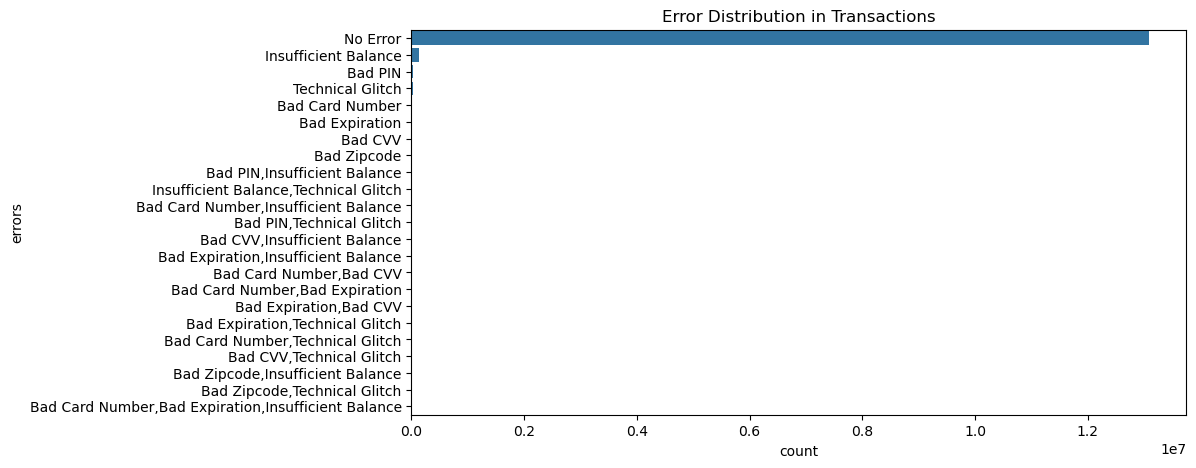

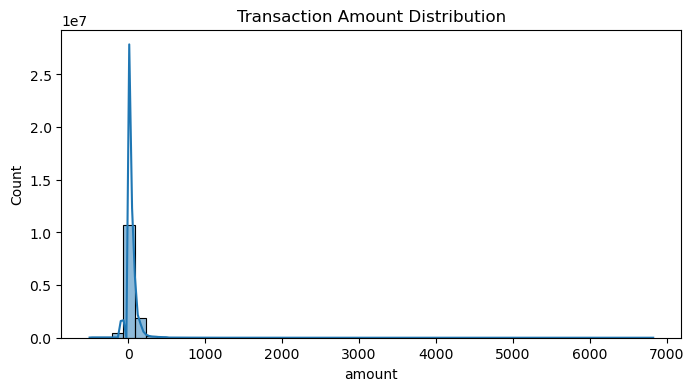

     merchant_city merchant_state  fraud_count
4253     Riverside  United States         2769
2318       Houston  United States         2217
3710       Orlando  United States         1547
1665    Farmington  United States         1538
1218        Dallas  United States         1450
2874   Los Angeles  United States         1416
202        Atlanta  United States         1346
3152         Miami  United States         1142
590       Brooklyn  United States         1008
2885    Louisville  United States          985


In [39]:

# --- 1. Data Cleaning & Preprocessing ---

# Handling missing values
transactions.fillna({"errors": "No Error"}, inplace=True)  # Filling missing errors with 'No Error'
users.dropna(inplace=True)  # Assuming all user data should be complete
cards.fillna({"credit_limit": cards["credit_limit"].median()}, inplace=True)  # Imputing median for missing credit limits

# Standardizing categorical data
transactions["use_chip"] = transactions["use_chip"].str.lower()
cards["card_brand"] = cards["card_brand"].str.title()
cards["card_type"] = cards["card_type"].str.title()

# Converting data types
transactions["zip"] = transactions["zip"].astype(str)  # Ensuring ZIP is a string

# --- 2. Exploratory Data Analysis (EDA) ---

# Summary statistics
print(transactions.describe())
print(users.describe())
print(cards.describe())

# Fraud distribution (error types)
plt.figure(figsize=(10, 5))
sns.countplot(y=transactions["errors"], order=transactions["errors"].value_counts().index)
plt.title("Error Distribution in Transactions")
plt.show()

# Transaction amount distribution
plt.figure(figsize=(8, 4))
sns.histplot(transactions["amount"], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()

# Fraud cases by merchant location
fraud_cases = transactions[transactions["errors"] != "No Error"]
fraud_by_location = fraud_cases.groupby(["merchant_city", "merchant_state"]).size().reset_index(name='fraud_count')
fraud_by_location = fraud_by_location.sort_values(by='fraud_count', ascending=False).head(10)
print(fraud_by_location)


In [40]:
import pandas as pd

# Define sampling fraction
sample_fraction = 0.20  # 20% of data

# Sample 20% from each fraud category while keeping proportions
df_sample = full_data.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=sample_fraction, random_state=42))

# Reset index after sampling
df_sample = df_sample.reset_index(drop=True)

# Print sample distribution
print(df_sample['target'].value_counts(normalize=True))  # Should match full_data's distribution
print(df_sample.shape)  # Check the sample size

/var/folders/8m/bs7t34sj2w71vsmtdl8hm8mw0000gn/T/ipykernel_85096/3992664148.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = full_data.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=sample_fraction, random_state=42))


target
0.0    0.998505
1.0    0.001495
Name: proportion, dtype: float64
(1782992, 41)


In [41]:
print(df_sample.columns)

Index(['id', 'date', 'client_id_trans', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors', 'date_part', 'time_part', 'category', 'target',
       'client_id_user', 'card_brand', 'card_type', 'card_number', 'expires',
       'cvv', 'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_on_dark_web', 'current_age',
       'retirement_age', 'birth_year', 'birth_month', 'gender', 'address',
       'latitude', 'longitude', 'per_capita_income', 'yearly_income',
       'total_debt', 'credit_score', 'num_credit_cards'],
      dtype='object')


In [42]:
# Create a new column for unusual locations by counting unique states per client_id_user
df_sample['unusual_location_count'] = df_sample.groupby('client_id_user')['merchant_state'].transform(lambda x: len(x.unique()))

In [43]:
# Convert the 'date' column to datetime if it's not already
df_sample['date'] = pd.to_datetime(df_sample['date'])

# Sort by client and date
df_sample = df_sample.sort_values(by=['client_id_user', 'date'])

# Calculate time difference (in seconds) between consecutive transactions for each client
df_sample['time_diff'] = df_sample.groupby('client_id_user')['date'].diff().dt.total_seconds()

# Count the number of transactions within the last hour (3600 seconds)
df_sample['transactions_last_hour'] = df_sample.groupby('client_id_user')['time_diff'].transform(
    lambda x: (x <= 3600).sum())



### Create the night_trans_count column

extract the hour from the date column and then filter for transactions that occurred between 1 AM and 4 AM.

In [45]:
# Extract the hour from the 'date' column
df_sample['hour'] = df_sample['date'].dt.hour

# Count night transactions (transactions between 1 AM and 4 AM)
df_sample['night_trans_count'] = df_sample['hour'].between(1, 4).astype(int)

### Rule Based Fraud Detection

Identify high-risk transactions using predefined rules.

#### create a sample dataframe

In [47]:
import numpy as np

# Rule 1: High amount and international transaction
df_sample['rule_1'] = (df_sample['amount'] > 900) & (df_sample['merchant_state'].isna())

# Rule 2: Unusual location (≥2 different states)
df_sample['rule_2'] = df_sample['unusual_location_count'] >= 2

# Rule 3: High-velocity transactions (≥10 in last hour)
df_sample['rule_3'] = df_sample['transactions_last_hour'] >= 10

# Rule 4: Extreme amount (>$999)
df_sample['rule_4'] = df_sample['amount'] > 999

# Rule 5: Night transactions (1AM-4AM)
df_sample['rule_5'] = df_sample['night_trans_count'] >= 5

# Compute total rule score
df_sample['rule_score'] = df_sample[['rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5']].sum(axis=1)

# Apply decisions
df_sample['decision'] = np.select(
    [df_sample['rule_score'] >= 3, 
     df_sample['rule_score'] == 2, 
     df_sample['rule_score'] == 1], 
    ['Block', 'Manual Review', 'Flag'], 
    default='Allow'
)

### logic:
a higher rule score leads to more severe actions like blocking, while lower rule scores lead to lighter actions like flagging.

	•	Block: Transactions that meet 3 or more rules.
	•	Manual Review: Transactions that meet exactly 2 rules.
	•	Flag: Transactions that meet only 1 rule.
	•	Allow: Transactions that meet none of the criteria.


#### Check how many transactions are flagged by the rules:

In [50]:
decision_counts = df_sample['decision'].value_counts()
print(decision_counts)

decision
Manual Review    1774154
Flag                7473
Block               1365
Name: count, dtype: int64


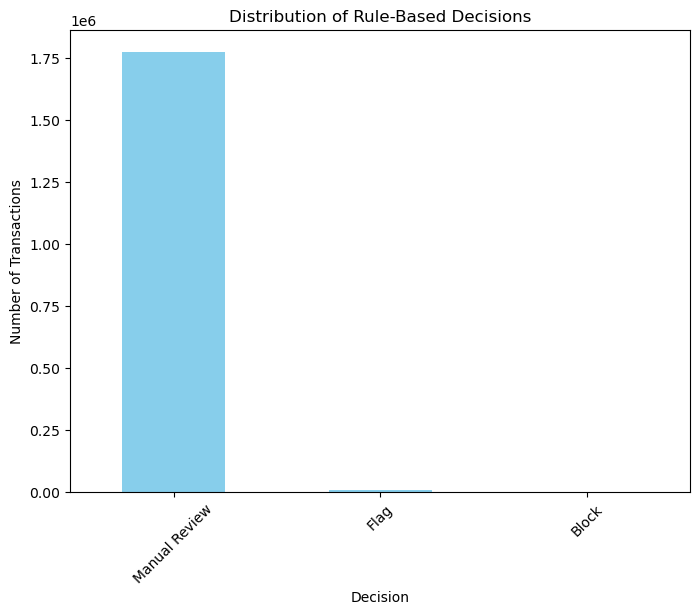

In [51]:
import matplotlib.pyplot as plt

# Visualize the distribution of decisions
plt.figure(figsize=(8, 6))
df_sample['decision'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Rule-Based Decisions')
plt.xlabel('Decision')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

####  Analyze Impact on Fraud Detection
assess how well your rule-based decisions align with the true fraud labels. For instance, you can check the accuracy, precision, recall, or F1-score of the decisions made by the rules compared to the actual fraud labels.

In [53]:
# Correct decision logic based on rule scores
df_sample['decision'] = np.select(
    [df_sample['rule_score'] >= 3, 
     df_sample['rule_score'] == 2, 
     df_sample['rule_score'] == 1], 
    ['Block', 'Manual Review', 'Flag'], 
    default='Allow'
)

# Verify the data types of 'target' and 'decision'
print(df_sample['target'].dtype)
print(df_sample['decision'].dtype)

# Map the decision to numeric values
decision_map = {
    'Allow': 0,
    'Block': 1,
    'Manual Review': 2,
    'Flag': 3
}

# Create the new 'decision_numeric' column
df_sample['decision_numeric'] = df_sample['decision'].map(decision_map)

# Print the classification report comparing target vs decision
print(classification_report(df_sample['target'], df_sample['decision_numeric'], target_names=['Allow', 'Block', 'Manual Review', 'Flag']))

float64
object


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/s

               precision    recall  f1-score   support

        Allow       0.00      0.00      0.00   1780326
        Block       0.01      0.01      0.01      2666
Manual Review       0.00      0.00      0.00         0
         Flag       0.00      0.00      0.00         0

     accuracy                           0.00   1782992
    macro avg       0.00      0.00      0.00   1782992
 weighted avg       0.00      0.00      0.00   1782992



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Rules from Tinybird article:

1. **High Amount Transactions**: The SQL checks for amount > 900. In the dataset, the 'amount' column is already a float, so we can create a boolean column for transactions exceeding this threshold.

2. **Unusual Location**: The SQL looks for transactions outside the user's usual locations. The user's usual locations can be determined by aggregating their transaction history. However, since the data might be large, we need an efficient way to compute this. Maybe group by user_id and check if the merchant_state is not in the user's common states.

3. **High-Velocity Transactions**: Counting transactions per user in the last hour. This requires tracking the timestamp and user_id. Since the data is historical, we can't use real-time intervals, but we can simulate it by checking time differences between consecutive transactions for each user.

4. **Unusually Large Transactions**: Similar to the first rule but with a higher threshold (e.g., >999). This is straightforward with a boolean condition.

5. **Unusual Times**: Transactions between 1 AM and 5 AM. Extract the hour from the timestamp and check if it's within that range.

6. **Declined Transactions**: The dataset has an 'errors' column. Assuming declined transactions are indicated here, count how many times a user has transactions with errors.

7. **High-Risk IP Addresses**: The example uses IP prefixes, but the dataset has 'merchant_id' and 'zip'. Maybe adapt this to check for high-risk merchants or zip codes. Alternatively, if there's an IP-related field, use that, but based on the current data, this might not be directly applicable.

8. **Unusual Spending Patterns**: Using statistical methods like z-scores to detect amounts that are 2 standard deviations above the mean for each user. This requires grouping by user and calculating mean and std, then comparing each transaction's amount.



### Apply to full_data

In [55]:
# Ensure 'date' column is in datetime format
full_data['date'] = pd.to_datetime(full_data['date'])

# Create a new column for unusual locations by counting unique states per client_id_user
full_data['unusual_location_count'] = full_data.groupby('client_id_user')['merchant_state'].transform(lambda x: len(x.unique()))

# Sort by client and date
full_data = full_data.sort_values(by=['client_id_user', 'date'])

# Calculate time difference (in seconds) between consecutive transactions for each client
full_data['time_diff'] = full_data.groupby('client_id_user')['date'].diff().dt.total_seconds()

# Count the number of transactions within the last hour (3600 seconds)
full_data['transactions_last_hour'] = full_data.groupby('client_id_user')['time_diff'].transform(
    lambda x: (x <= 3600).sum())

# Extract the hour from the 'date' column
full_data['hour'] = full_data['date'].dt.hour

# Count night transactions (transactions between 1 AM and 4 AM)
full_data['night_trans_count'] = full_data['hour'].between(1, 4).astype(int)

# Rule 1: High amount and international transaction
full_data['rule_1'] = (full_data['amount'] > 900) & (full_data['merchant_state'].isna())

# Rule 2: Unusual location (≥2 different states)
full_data['rule_2'] = full_data['unusual_location_count'] >= 2

# Rule 3: High-velocity transactions (≥10 in last hour)
full_data['rule_3'] = full_data['transactions_last_hour'] >= 10

# Rule 4: Extreme amount (>$999)
full_data['rule_4'] = full_data['amount'] > 999

# Rule 5: Night transactions (1AM-4AM)
full_data['rule_5'] = full_data['night_trans_count'] >= 5

# Compute total rule score
full_data['rule_score'] = full_data[['rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5']].sum(axis=1)

# Apply decisions with severity logic
full_data['decision'] = np.select(
    [full_data['rule_score'] >= 3,  # Severe transactions (high rule score)
     full_data['rule_score'] == 2,  # Moderate severity transactions
     full_data['rule_score'] == 1], # Low severity transactions
    ['Block', 'Manual Review', 'Flag'],  # Corrected decision application
    default='Allow'  # If none of the above, the transaction is allowed
)

# Now you can check the resulting dataframe to verify the decisions
print(full_data[['client_id_user', 'amount', 'merchant_state', 'rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5', 'rule_score', 'decision']].head())

     client_id_user  amount merchant_state  rule_1  rule_2  rule_3  rule_4  \
1795              0   33.96  United States   False    True    True   False   
2960              0    7.78  United States   False    True    True   False   
3299              0   65.86  United States   False    True    True   False   
4955              0   55.85  United States   False    True    True   False   
8801              0    1.37  United States   False    True    True   False   

      rule_5  rule_score       decision  
1795   False           2  Manual Review  
2960   False           2  Manual Review  
3299   False           2  Manual Review  
4955   False           2  Manual Review  
8801   False           2  Manual Review  


In [56]:
# Print the distribution of decisions with the updated severity logic
print(full_data['decision'].value_counts())

# Print the first few rows of the dataset to verify the applied rules and decisions
print(full_data[['client_id_user', 'amount', 'merchant_state', 'rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5', 'rule_score', 'decision']].head())

decision
Manual Review    13296042
Block                9873
Name: count, dtype: int64
     client_id_user  amount merchant_state  rule_1  rule_2  rule_3  rule_4  \
1795              0   33.96  United States   False    True    True   False   
2960              0    7.78  United States   False    True    True   False   
3299              0   65.86  United States   False    True    True   False   
4955              0   55.85  United States   False    True    True   False   
8801              0    1.37  United States   False    True    True   False   

      rule_5  rule_score       decision  
1795   False           2  Manual Review  
2960   False           2  Manual Review  
3299   False           2  Manual Review  
4955   False           2  Manual Review  
8801   False           2  Manual Review  


In [57]:
# Check the distribution of rule scores
print(full_data['rule_score'].value_counts())

rule_score
2    13296042
3        7981
4        1892
Name: count, dtype: int64
